# <center>COVID-19 Detection using Chest X-Ray via CNN and Gradient Based Class Activation Map</center>

![](https://spectrum.ieee.org/image/MzYwMjU0NA.jpeg)

Coronavirus disease 2019 (COVID-19) is a highly infectious disease caused by severe acute respiratory syndrome coronavirus 2. The disease first originated in December 2919 from Wuhan, China and since then it has spread globally across the world affecting more than 200 countries.

## Current Methodologies

### 1. Molecular tests:

They usually involve taking a sample from the back of the throat with a cotton swab. The doctor then sends the sample off for testing.The sample will undergo a polymerase chain reaction (PCR) test. This type of test detects signs of the virus’s genetic material.

### 2. Serological tests:

These tests detect antibodies that the body produces to fight the virus. These antibodies are present in anyone who has recovered from COVID-19.The antibodies exist in blood and tissues throughout the body. A serological test usually requires a blood sample.



In [0]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download --unzip 'tawsifurrahman/covid19-radiography-database'
! rm -rf 'COVID-19 Radiography Database'/'Viral Pneumonia'
! rm -rf 'COVID-19 Radiography Database'/*.xlsx

Saving kaggle.json to kaggle.json
 99% 1.13G/1.15G [00:04<00:00, 276MB/s]
100% 1.15G/1.15G [00:04<00:00, 248MB/s]


In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import PIL
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from math import ceil
import math
import sys
import gc

import keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.activations import softmax
from tensorflow.keras.activations import elu
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD,Adagrad,Adadelta
from tensorflow.keras.layers import BatchNormalization
from tqdm import tqdm
import tensorflow as tf
import shutil
import random
from shutil import copyfile
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")
gc.enable()

Using TensorFlow backend.


In [0]:
BASE_PATH="/content/COVID-19 Radiography Database/"
COVID_DATA_PATH="/content/COVID-19 Radiography Database/COVID-19/"
NORMAL_DATA_PATH="/content/COVID-19 Radiography Database/NORMAL/"

n_covid_files=len(os.listdir(COVID_DATA_PATH))
n_normal_files=len(os.listdir(NORMAL_DATA_PATH))

print(f"The no of COVID-19 Xray Scans are {n_covid_files} and no of NORMAL xray scans are {n_normal_files}")

The no of COVID-19 Xray Scans are 219 and no of NORMAL xray scans are 1341


As Observed we may need to sample some 220 examples from normal scans to keep the dataset balanced , lets do that and create the correct folder structure for the training and testing dataset.

In [0]:
shutil.rmtree('/tmp')
try:
    directory="/tmp/covid_vs_normal"
    if not os.path.exists(directory):
        os.makedirs(directory+"/training/covid")
        os.makedirs(directory+"/training/normal")
        os.makedirs(directory+"/testing/covid")
        os.makedirs(directory+"/testing/normal")
except OSError:
    pass

## Data Glance

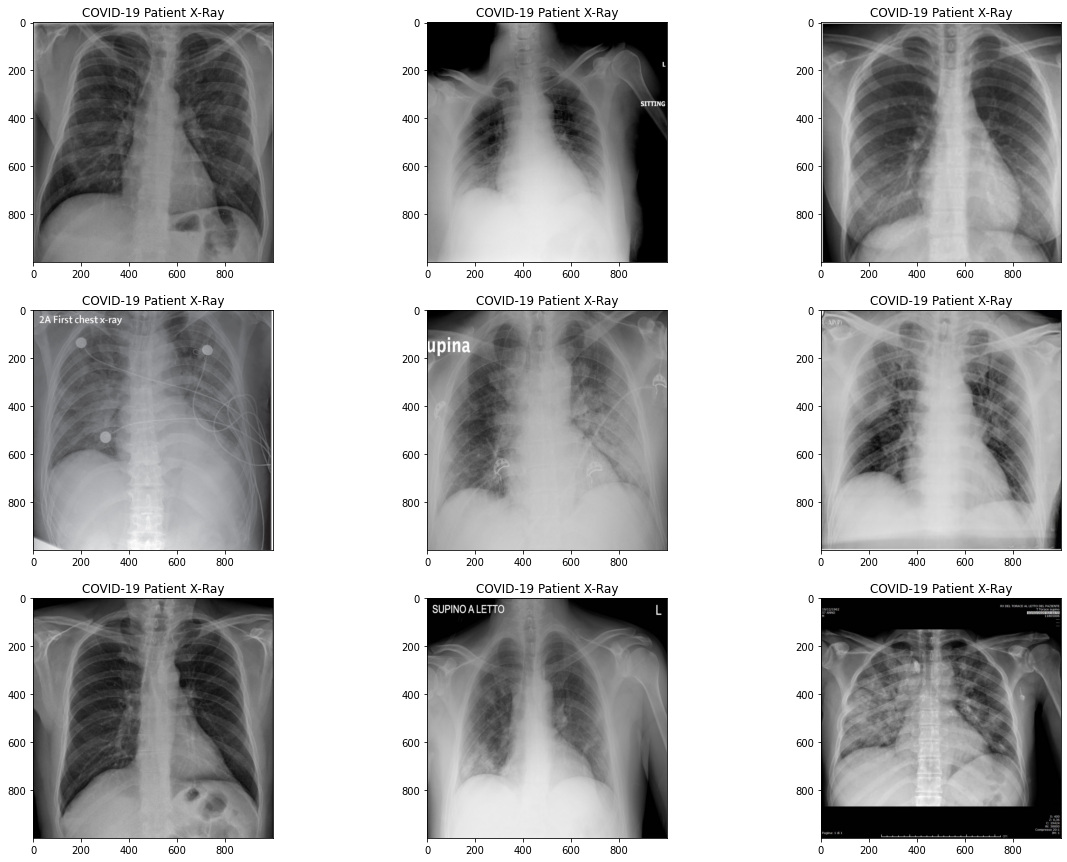

In [0]:
fig = plt.figure(figsize=(20, 15))
for index, image_file in enumerate(os.listdir(COVID_DATA_PATH)[:9]):
        ax = fig.add_subplot(3,3, index+1)
        path=COVID_DATA_PATH+image_file
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (1000, 1000))
        plt.imshow(image)
        ax.set_title("COVID-19 Patient X-Ray")
plt.show()

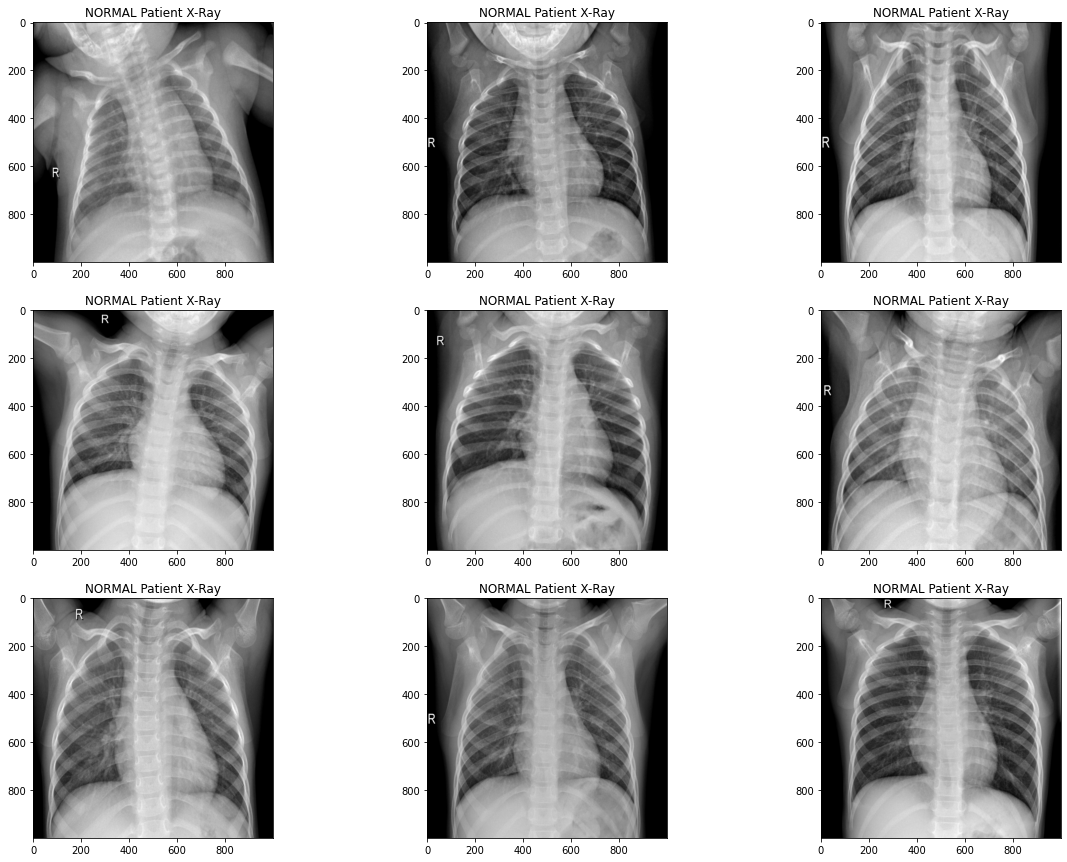

In [0]:
fig = plt.figure(figsize=(20, 15))
for index, image_file in enumerate(os.listdir(NORMAL_DATA_PATH)[:9]):
        ax = fig.add_subplot(3,3, index+1)
        path=NORMAL_DATA_PATH+image_file
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (1000, 1000))
        plt.imshow(image)
        ax.set_title("NORMAL Patient X-Ray")
plt.show()

In [0]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE, SPLIT):
    if SPLIT=="NORMAL": 
      all_files=os.listdir(SOURCE)
      down_Sample_files=random.sample(all_files, int(len(all_files)*0.17))
      train_files=random.sample(down_Sample_files, int(len(down_Sample_files)*SPLIT_SIZE))
    else:
      all_files=os.listdir(SOURCE)
      train_files=random.sample(all_files, int(len(all_files)*SPLIT_SIZE))
    #print(train_files)
    for f in train_files: copyfile(SOURCE+f, TRAINING+f)
    for f in os.listdir(SOURCE):
      if SPLIT=="NORMAL": 
        if f not in train_files and f in down_Sample_files:
            copyfile(SOURCE+f, TESTING+f)
      else:
        if f not in train_files:
            copyfile(SOURCE+f, TESTING+f)


COVID_SOURCE_DIR = COVID_DATA_PATH
TRAINING_COVID_DIR = "/tmp/covid_vs_normal/training/covid/"
TESTING_COVID_DIR = "/tmp/covid_vs_normal/testing/covid/"
NORMAL_SOURCE_DIR = NORMAL_DATA_PATH
TRAINING_NORMAL_DIR = "/tmp/covid_vs_normal/training/normal/"
TESTING_NORMAL_DIR = "/tmp/covid_vs_normal/testing/normal/"

split_size = .8
split_data(COVID_SOURCE_DIR, TRAINING_COVID_DIR, TESTING_COVID_DIR, split_size, "COVID")
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, split_size, 'NORMAL')

training_covid_files=len(os.listdir(TRAINING_COVID_DIR))
training_normal_files=len(os.listdir(TRAINING_NORMAL_DIR))
testing_covid_files=len(os.listdir(TESTING_COVID_DIR))
testing_normal_files=len(os.listdir(TESTING_NORMAL_DIR))

print(f"The no of COVID-19 Xray Scans in train are {training_covid_files} and test are {testing_covid_files}")
print(f"The no of NORMAL Xray Scans in train are {training_normal_files} and test are {testing_normal_files}")

The no of COVID-19 Xray Scans in train are 175 and test are 44
The no of NORMAL Xray Scans in train are 181 and test are 46


In [0]:
INPUT_SHAPE=224

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)


TRAINING_DIR ="/tmp/covid_vs_normal/training/"
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  fill_mode='nearest',
                                  horizontal_flip=True,
                                  vertical_flip=True)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                   batch_size=16,
                                                   target_size=(INPUT_SHAPE, INPUT_SHAPE),
                                                   class_mode="categorical")

VALIDATION_DIR = "/tmp/covid_vs_normal/testing/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)


validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                   batch_size=10,
                                                   target_size=(INPUT_SHAPE, INPUT_SHAPE),
                                                   class_mode="categorical")
gc.collect()

Found 356 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


0

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

  
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'



--2020-04-06 08:44:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.5.80, 2607:f8b0:4007:80d::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.5.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  69.6MB/s    in 1.2s    

2020-04-06 08:44:20 (69.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
pre_trained_model = InceptionV3(input_shape=(INPUT_SHAPE,INPUT_SHAPE,3),
                               weights=None,
                               include_top=False)

pre_trained_model.load_weights(local_weights_file)


for layer in pre_trained_model.layers:
    layer.trainable=False
  
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense(2, activation="softmax")(x)           

model = tf.keras.models.Model(pre_trained_model.input, x) 

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.00001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(train_generator,
                              epochs=3,
                              steps_per_epoch=25,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=4)

for layers in model.layers:
    layers.trainable = True

history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=25,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=4,
                              callbacks=[early_stop, 
                                         reduce_lr])

last layer output shape:  (None, 12, 12, 768)
Epoch 1/3
25/25 [==============================] - 14s 561ms/step - loss: 0.4072 - acc: 0.8325 - val_loss: 0.1724 - val_acc: 0.9750
Epoch 2/3
25/25 [==============================] - 13s 533ms/step - loss: 0.1766 - acc: 0.9536 - val_loss: 0.1780 - val_acc: 0.9500
Epoch 3/3
25/25 [==============================] - 13s 521ms/step - loss: 0.1627 - acc: 0.9562 - val_loss: 0.0656 - val_acc: 0.9750
Epoch 1/100
25/25 [==============================] - 13s 525ms/step - loss: 0.1001 - acc: 0.9691 - val_loss: 0.3060 - val_acc: 0.9000 - lr: 1.0000e-05
Epoch 2/100
25/25 [==============================] - 13s 529ms/step - loss: 0.1202 - acc: 0.9588 - val_loss: 0.2464 - val_acc: 0.9000 - lr: 1.0000e-05
Epoch 3/100
25/25 [==============================] - 13s 507ms/step - loss: 0.1117 - acc: 0.9639 - val_loss: 0.0335 - val_acc: 0.9750 - lr: 1.0000e-05
Epoch 4/100
25/25 [==============================] - 13s 530ms/step - loss: 0.1457 - acc: 0.9628 - val_lo

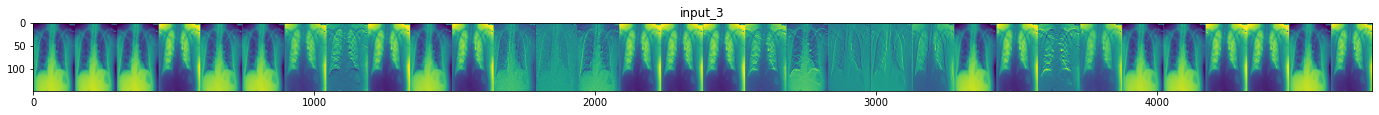

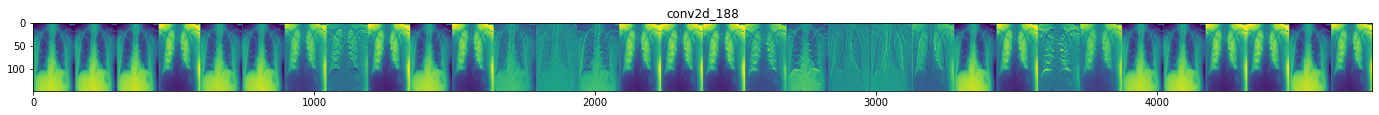

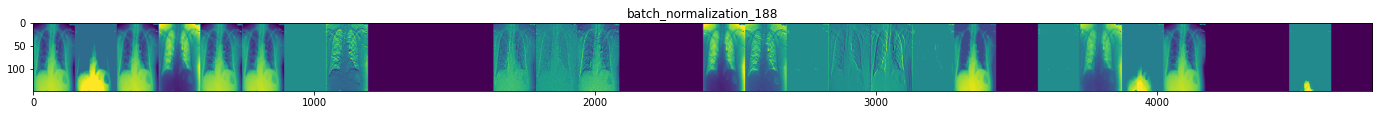

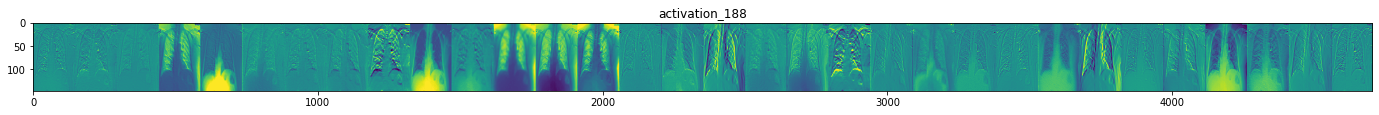

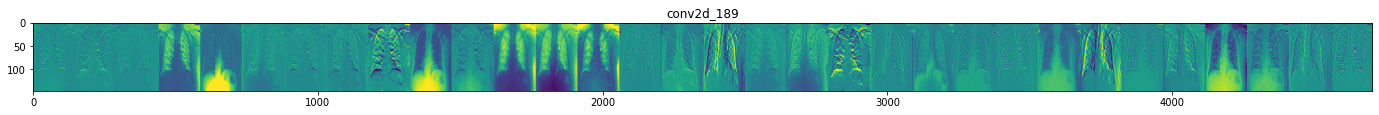

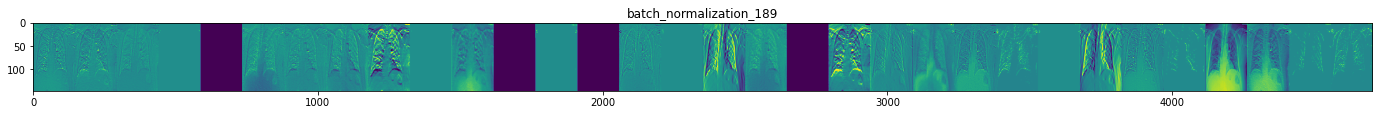

In [0]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:7]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
#horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
#human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
#img_path = random.choice(horse_img_files + human_img_files)
img_path="/tmp/covid_vs_normal/training/covid/COVID-19(166).png"
img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features*1.2, scale*2))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [0]:
from tensorflow.keras.applications import DenseNet121, InceptionResNetV2, ResNet152V2, VGG16, VGG19, InceptionV3
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

def create_model(img_dim, CHANNEL):
    input_tensor = tf.keras.layers.Input(shape=(img_dim, img_dim, CHANNEL))
    base_model = VGG16(weights="imagenet", include_top=False, input_tensor=input_tensor)
    back_layers=base_model.layers[-8]
    x = tf.keras.layers.GlobalAveragePooling2D(name="fine_tine")(base_model.output)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    output_layer = tf.keras.layers.Dense(2, activation='softmax', name="Output_Layer")(x)
    model= tf.keras.models.Model(input_tensor, output_layer)
    return model


model = create_model(INPUT_SHAPE, 3)
#model.summary()
for layers in model.layers[:-13]:
    layers.trainable = False

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(train_generator,
                              epochs=3,
                              steps_per_epoch=25,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=4)

for layers in model.layers:
    layers.trainable = True
history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=25,
                              verbose=1,
                              validation_data=validation_generator,
                              validation_steps=4,
                              callbacks=[early_stop, 
                                         reduce_lr])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
25/25 [==============================] - 12s 475ms/step - loss: 0.6934 - acc: 0.6598 - val_loss: 0.3313 - val_acc: 0.9500
Epoch 2/3
25/25 [==============================] - 13s 501ms/step - loss: 0.4476 - acc: 0.8325 - val_loss: 0.2521 - val_acc: 0.9500
Epoch 3/3
25/25 [==============================] - 12s 488ms/step - loss: 0.2759 - acc: 0.9175 - val_loss: 0.2286 - val_acc: 0.9000
Epoch 1/100
25/25 [==============================] - 12s 497ms/step - loss: 0.2642 - acc: 0.9098 - val_loss: 0.0532 - val_acc: 1.0000 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 12s 488ms/step - loss: 0.1973 - acc: 0.9278 - val_loss: 0.6395 - val_acc: 0.7750 - lr: 1.0000e-04
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.2230 - acc: 0.9433
Epoch 00003: ReduceLROnPlateau reducing learning rate t

## <center> Gradient-weighted Class Activation Mapping - Grad-CAM </center>

A technique for making Convolutional Neural Network (CNN)-based models more transparent by visualizing the regions of input that are “important” for predictions from these models — or visual explanations

![](https://miro.medium.com/proxy/1*U1VdM0WeXHVzVFLyj1ePzw.jpeg)

This visualization is both high-resolution (when the class of interest is ‘tiger cat’, it identifies important ‘tiger cat’ features like stripes, pointy ears and eyes) and class-discriminative (it shows the ‘tiger cat’ but not the ‘boxer (dog)’).

### <center>Proposed Approach</center>

![](https://miro.medium.com/proxy/1*hHPn81BbKEl7xDsHr5aSIA.png)

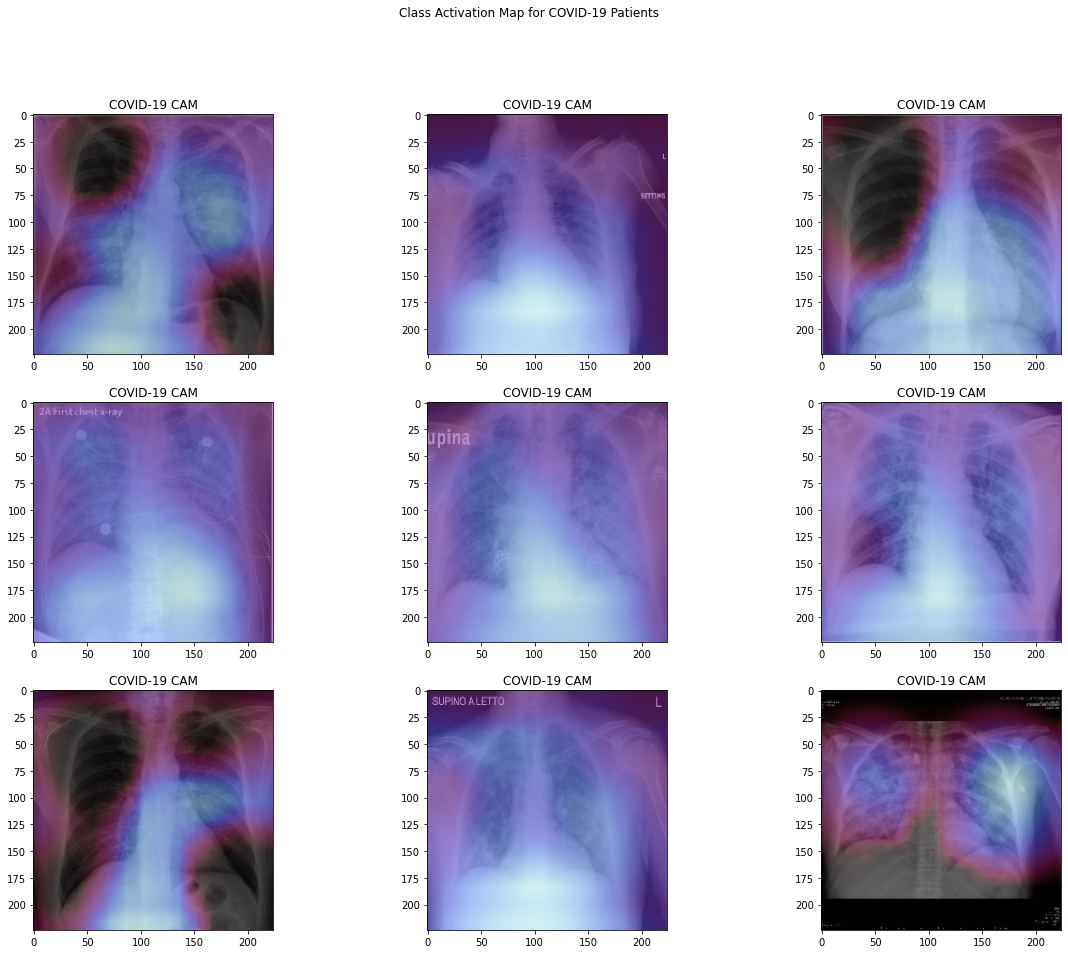

In [0]:
def get_class_activation_map(img_path) :
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img,axis=0)
    img=img/255
    predict = model.predict(img)
    target_class = np.argmax(predict[0])
    last_conv = model.get_layer('block5_conv3')
    grads =K.gradients(model.output[:,target_class],last_conv.output)[0]
    pooled_grads = K.mean(grads,axis=(0,1,2))
    iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
    pooled_grads_value,conv_layer_output = iterate([img])
 
    
    for i in range(512):
        conv_layer_output[:,:,i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output,axis=-1)
 
    for x in range(heatmap.shape[0]):
        for y in range(heatmap.shape[1]):
            heatmap[x,y] = np.max(heatmap[x,y],0)

    img=img.reshape(224, 224, 3)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_MAGMA)
    superimposed_img = cv2.addWeighted(img, 0.45, heatmap, 0.55, 0)
    #plt.figure(figsize=(8, 8))
    #plt.imshow(img)
    #plt.imshow(superimposed_img)
    return (img, superimposed_img)


fig = plt.figure(figsize=(20, 15))
for index, image_file in enumerate(os.listdir(COVID_DATA_PATH)[:9]):
        ax = fig.add_subplot(3,3, index+1)
        img, superimposed_img=get_class_activation_map(COVID_DATA_PATH+image_file)
        plt.imshow(img)
        plt.imshow(superimposed_img)
        ax.set_title("COVID-19 CAM")
fig.suptitle("Class Activation Map for COVID-19 Patients")
plt.show()

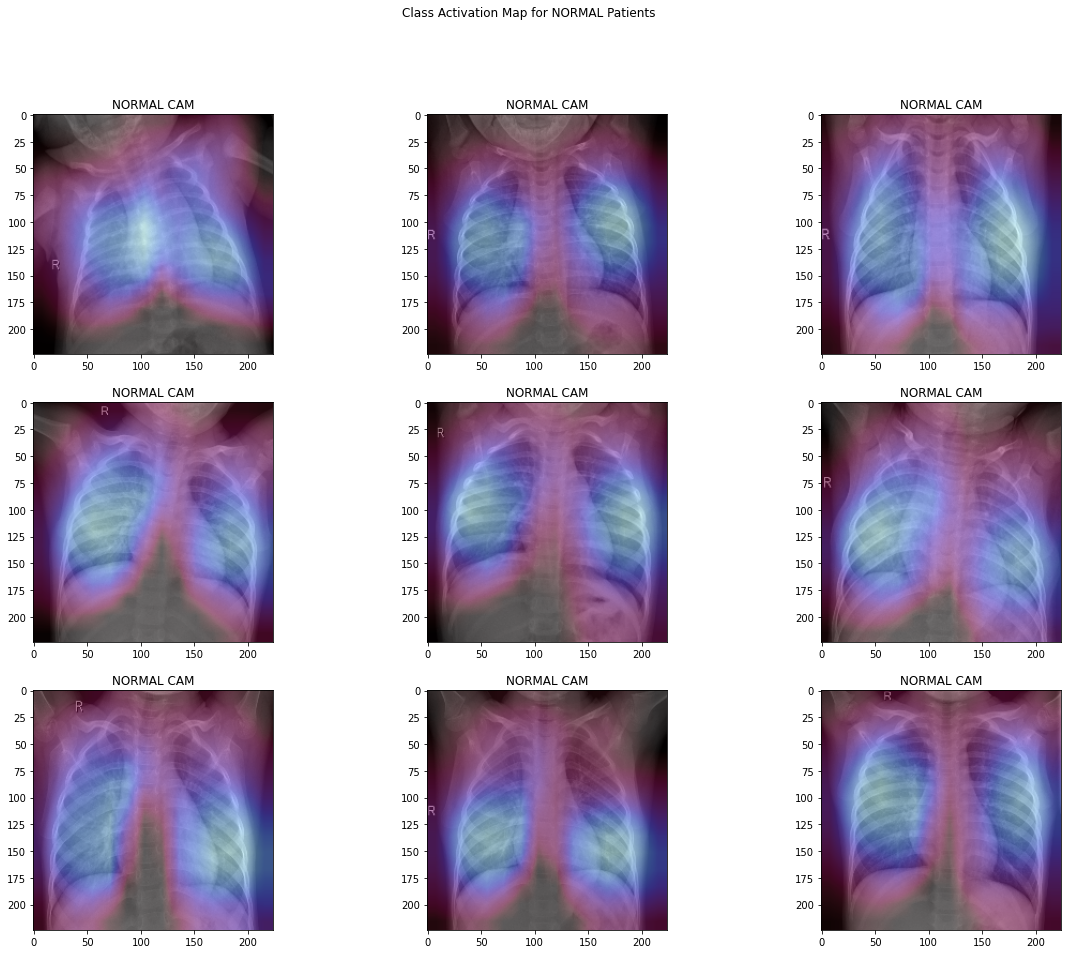

In [0]:
fig = plt.figure(figsize=(20, 15))
for index, image_file in enumerate(os.listdir(NORMAL_DATA_PATH)[:9]):
        ax = fig.add_subplot(3,3, index+1)
        img, superimposed_img=get_class_activation_map(NORMAL_DATA_PATH+image_file)
        plt.imshow(img)
        plt.imshow(superimposed_img)
        ax.set_title("NORMAL CAM")
fig.suptitle("Class Activation Map for NORMAL Patients")
plt.show()